In [3]:
!unzip "/content/dataset.zip" -d "/content/emnist".  #unzipping th file

Streaming output truncated to the last 5000 lines.
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (630).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (631).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (632).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (633).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (634).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (635).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (636).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (637).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (638).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (639).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (64).jpg  
  inflating: /content/emnist/Vehicles/Auto Rickshaws/Auto Rickshaw (640).jpg  
  

In [4]:
import os

for root, dirs, files in os.walk("/content/emnist"):
    print("Current folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    print("-" * 50)


Current folder: /content/emnist
Subfolders: ['Vehicles']
Files: []
--------------------------------------------------
Current folder: /content/emnist/Vehicles
Subfolders: ['Ships', 'Cars', 'Planes', 'Trains', 'Bikes', 'Auto Rickshaws', 'Motorcycles']
Files: []
--------------------------------------------------
Current folder: /content/emnist/Vehicles/Ships
Subfolders: []
Files: ['Ship (3).jpg', 'Ship (764).jpg', 'Ship (542).jpg', 'Ship (116).jpg', 'Ship (79).jpg', 'Ship (112).jpg', 'Ship (716).jpg', 'Ship (176).jpg', 'Ship (26).jpg', 'Ship (739).jpg', 'Ship (260).jpg', 'Ship (454).jpg', 'Ship (493).jpg', 'Ship (709).jpg', 'Ship (538).jpg', 'Ship (42).jpg', 'Ship (732).jpg', 'Ship (391).jpg', 'Ship (171).jpg', 'Ship (569).jpg', 'Ship (781).jpg', 'Ship (710).jpg', 'Ship (530).jpg', 'Ship (96).jpg', 'Ship (242).jpg', 'Ship (2).jpg', 'Ship (103).jpg', 'Ship (563).jpg', 'Ship (175).jpg', 'Ship (534).jpg', 'Ship (730).jpg', 'Ship (797).jpg', 'Ship (85).jpg', 'Ship (236).jpg', 'Ship (403).jpg

In [5]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader


In [8]:
# Path to your dataset
data_dir = "/content/emnist/Vehicles"

# Transform: convert image to tensor (and optionally resize/normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),       # Resize all images to 64x64
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize (optional but helpful)
])


In [9]:
# Create label map
class_names = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

# Prepare data and labels
data = []
labels = []

# Walk through each class folder
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            image = Image.open(img_path).convert("RGB")
            image = transform(image)
            data.append(image)
            labels.append(class_to_idx[class_name])
        except Exception as e:
            print(f"Error loading {img_path}: {e}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
# Stack all images and labels into tensors
images_tensor = torch.stack(data)
labels_tensor = torch.tensor(labels)

# Wrap into a PyTorch Dataset
dataset = TensorDataset(images_tensor, labels_tensor)

In [11]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
# Check the first batch
for batch_images, batch_labels in dataloader:
    print("Image batch shape:", batch_images.shape)
    print("Label batch shape:", batch_labels.shape)
    break


Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class VehicleCNN(nn.Module):
    def __init__(self, num_classes):
        super(VehicleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [B, 16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))   # [B, 32, 16, 16]
        x = x.view(-1, 32 * 16 * 16)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VehicleCNN(num_classes=len(class_to_idx)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/5, Loss: 1.1522
Epoch 2/5, Loss: 0.6996
Epoch 3/5, Loss: 0.5263
Epoch 4/5, Loss: 0.4048
Epoch 5/5, Loss: 0.2987


In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=32, shuffle=False)

# Then use `test_loader` in a loop for evaluation like accuracy


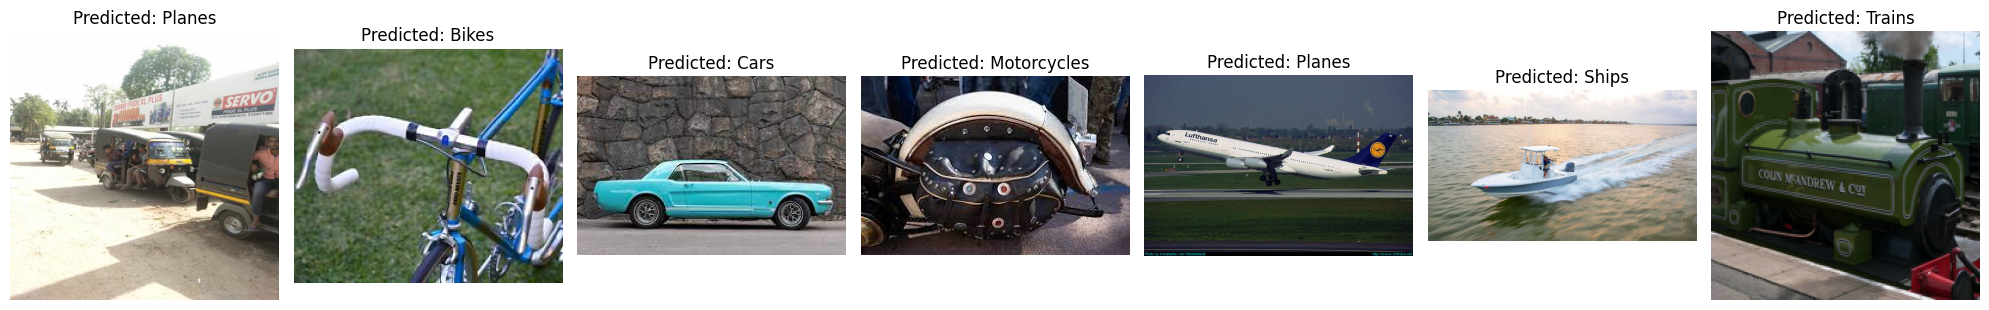

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch

# Make sure model is in eval mode
model.eval()

# Set up the plot
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))

# Loop through one image per class
for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir, class_name)
    image_file = os.listdir(class_folder)[0]  # Pick the first image
    image_path = os.path.join(class_folder, image_file)

    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = class_names[predicted.item()]

    # Display
    axes[idx].imshow(img)
    axes[idx].set_title(f"Predicted: {predicted_label}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()